# Song Recommendation System on Amazon Dataset

In [1]:
# Importing header files
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cross_validation as cv
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
from math import sqrt
import string
import operator
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

/home/mauli/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Importing Reviews Dataset

In [2]:
# Importing review datset for review based recommender
reviews_music_df = pd.read_json("data/reviews_Digital_Music_5.json", lines=True)
reviews_music_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000


## Importing Ratings Dataset

In [3]:
# Importing rating datset for rating based recommender
header = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_music_df = pd.read_csv('data/ratings_Digital_Music.csv', names=header)
ratings_music_df.head()

,user_id,item_id,rating,timestamp
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200


## EDA

In [4]:
# Complete Dataset
n_users_complete = ratings_music_df.user_id.unique().shape[0]
n_items_complete = ratings_music_df.item_id.unique().shape[0]
print('Total Number of rows = ', str(ratings_music_df.shape[0]))
print ('Number of users = ' , str(n_users_complete) , ' | Number of items = ' , str(n_items_complete))

Total Number of rows =  836006
Number of users =  478235  | Number of items =  266414


In [5]:
# Sparsity of Complete Dataset
sparsity_complete = round(1.0-len(ratings_music_df)/float(n_users_complete * n_items_complete),3)
print ('The sparsity level of Complete Music Dataset is ' ,  str(sparsity_complete*100) , '%')

The sparsity level of Complete Music Dataset is  100.0 %


In [6]:
# First 10000 rows
ratings_music_df_10000 = ratings_music_df.head(10000)
n_users = ratings_music_df_10000.user_id.unique().shape[0]
n_items = ratings_music_df_10000.item_id.unique().shape[0]
print('Total Number of rows = ', str(ratings_music_df_10000.shape[0]))
print ('Number of users = ' , str(n_users) , ' | Number of items = ' , str(n_items))

Total Number of rows =  10000
Number of users =  8355  | Number of items =  500


In [7]:
# Sparsity of first 10000 rows Dataset
sparsity_10000 = round(1.0-len(ratings_music_df_10000)/float(n_users*n_items),3)
print ('The sparsity level of Music dataset 10000 is ' ,  str(sparsity_10000*100) , '%')

The sparsity level of Music dataset 10000 is  99.8 %


In [8]:
# Calculating mean for each items (song)
ratings_music_df_10000.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()

item_id
B00000027R    5.0
B000000YNA    5.0
B0000002VC    5.0
B000000EYE    5.0
B000000EYL    5.0
Name: rating, dtype: float64

In [9]:
# Calculating count for each items (song)
ratings_music_df_10000.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
B00000016W    600
B00000064G    276
B000000TDH    219
B000000OUJ    195
B00000053X    162
Name: rating, dtype: int64

In [10]:
# Calculating mean for each items (song) and convert to DataFrame
ratings_mean = pd.DataFrame(ratings_music_df_10000.groupby('item_id')['rating'].mean())
ratings_mean.head()

,rating
item_id,
5555991584,4.638462
6308051551,5.000000
7901622466,4.823529
B0000000ZW,4.333333
B00000016T,4.719008


In [11]:
# Calculating mean for each items (song) and convert to DataFrame merge count to it
ratings_mean['rating_numbers'] = pd.DataFrame(ratings_music_df_10000.groupby('item_id')['rating'].count())
ratings_mean.head()

,rating,rating_numbers
item_id,,
5555991584,4.638462,130
6308051551,5.000000,2
7901622466,4.823529,17
B0000000ZW,4.333333,21
B00000016T,4.719008,121


In [12]:
# Sort ratings_mean according to ratings_count
ratings_mean.sort_values('rating_numbers', ascending=False).head()

,rating,rating_numbers
item_id,,
B00000016W,4.433333,600
B00000064G,4.760870,276
B000000TDH,4.584475,219
B000000OUJ,4.866667,195
B00000053X,4.067901,162


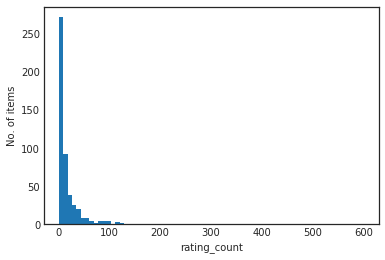

In [13]:
# Plot of ratings count
#ratings_mean['rating_numbers'].hist(bins=70)
plt.hist(ratings_mean['rating_numbers'], bins=70)
plt.xlabel('rating_count')
plt.ylabel('No. of items')
plt.show()

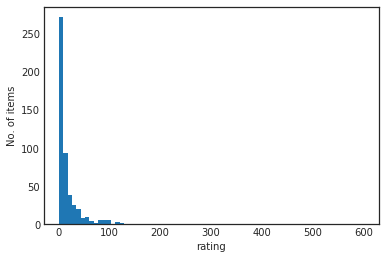

In [14]:
# Plot of rating
#ratings_mean['rating'].hist(bins=70)
plt.hist(ratings_mean['rating_numbers'], bins=70)
plt.xlabel('rating')
plt.ylabel('No. of items')
plt.show()

/home/mauli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/mauli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


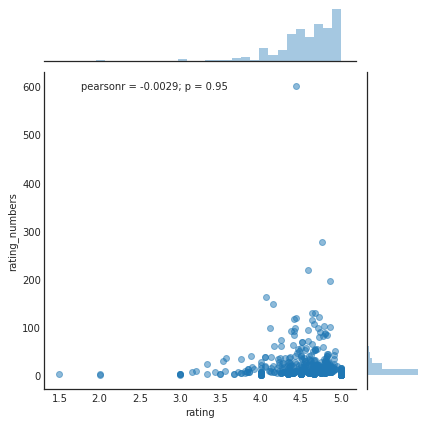

In [15]:
# Join Plot
sns.jointplot(x='rating', y='rating_numbers', data=ratings_mean, alpha=0.5)

## Correlation based Recommender

In [16]:
# Create ratings matrix
ratings_matrix = ratings_music_df_10000.pivot_table(index='user_id', columns='item_id', values='rating')
ratings_matrix.head()

item_id,5555991584,6308051551,7901622466,B0000000ZW,B00000016T,B00000016W,B00000017R,B0000001BA,B0000001BO,B0000001O0,...,B0000011CU,B0000011GU,B0000011MD,B0000011N5,B0000011P7,B0000011WE,B0000011X5,B0000011XM,B00000127G,B0000012T3
user_id,,,,,,,,,,,,,,,,,,,,,
A04345582HHNXEA9SAET4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A07465992K7FVSL53VA9B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A08161909WK3HU7UYTMW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A086594320Z777EHOFWKU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10175AMUHOQC4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Ratings of that product
B00000016W_user_ratings = ratings_matrix['B00000016W']
B000000TDH_user_ratings = ratings_matrix['B000000TDH']

In [18]:
# Correlation of the product with matrix
similar_to_B00000016W = ratings_matrix.corrwith(B00000016W_user_ratings)
similar_to_B000000TDH = ratings_matrix.corrwith(B000000TDH_user_ratings)

/home/mauli/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/mauli/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [19]:
# Convert to DataFrame
corr_B00000016W = pd.DataFrame(similar_to_B00000016W, columns=['Correlation'])
corr_B00000016W.dropna(inplace=True)
corr_B00000016W.head()

,Correlation
item_id,
B00000016W,1.000000
B00000017R,1.000000
B0000002ME,-0.333333
B00000053B,-1.000000
B00000064E,0.612372


In [20]:
# Convert to DataFrame
corr_B000000TDH = pd.DataFrame(similar_to_B000000TDH, columns=['Correlation'])
corr_B000000TDH.dropna(inplace=True)
corr_B000000TDH.head()

,Correlation
item_id,
B00000016W,0.771744
B00000053X,0.632456
B0000009OU,1.000000
B000000OPC,1.000000
B000000OVC,1.000000


In [21]:
# Sort the items, based on correlation
corr_B00000016W.sort_values('Correlation', ascending=False).head()

,Correlation
item_id,
B00000016W,1.0
B000000OPC,1.0
B000000OME,1.0
B000000I0D,1.0
B000000YDT,1.0


In [22]:
# Sort the items, based on correlation
corr_B000000TDH.sort_values('Correlation', ascending=False).head()

,Correlation
item_id,
B000000TDH,1.000000
B0000009OU,1.000000
B000000OPC,1.000000
B000000OVC,1.000000
B000000WGF,0.891042


In [23]:
# Join ratings count
corr_B00000016W = corr_B00000016W.join(ratings_mean['rating_numbers'], how='left', lsuffix='_left', rsuffix='_right')
corr_B00000016W.head()

,Correlation,rating_numbers
item_id,,
B00000016W,1.000000,600
B00000017R,1.000000,82
B0000002ME,-0.333333,129
B00000053B,-1.000000,58
B00000064E,0.612372,107


In [24]:
# Sorting based on correlation and subset based on rating_numbers > 100
corr_B00000016W[corr_B00000016W['rating_numbers']>100].sort_values('Correlation', ascending=False).head()

,Correlation,rating_numbers
item_id,,
B00000016W,1.000000,600
B000000OMB,0.800000,117
B000000TDH,0.771744,219
B00000064E,0.612372,107
B00000064G,-0.207436,276


In [25]:
# Join ratings count
corr_B000000TDH = corr_B000000TDH.join(ratings_mean['rating_numbers'], how='left', lsuffix='_left', rsuffix='_right')
corr_B000000TDH.head()

,Correlation,rating_numbers
item_id,,
B00000016W,0.771744,600
B00000053X,0.632456,162
B0000009OU,1.000000,87
B000000OPC,1.000000,46
B000000OVC,1.000000,38


In [26]:
# Sorting based on correlation and subset based on rating_numbers > 100
corr_B000000TDH[corr_B000000TDH['rating_numbers']>100].sort_values('Correlation', ascending=False).head()

,Correlation,rating_numbers
item_id,,
B000000TDH,1.000000,219
B00000016W,0.771744,600
B00000053X,0.632456,162


## Similarity based Recommender (cosine, euclidean, manhattan)

In [27]:
# Taking only first 10000 rows 
ratings_music_df_10000.head()

,user_id,item_id,rating,timestamp
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200


In [28]:
# Print Number of reviewers and number of items
n_users = ratings_music_df_10000.user_id.unique().shape[0]
n_items = ratings_music_df_10000.item_id.unique().shape[0]
print ('Number of users = ' , str(n_users) , ' | Number of items = ' , str(n_items))

Number of users =  8355  | Number of items =  500


In [29]:
# Train and Test split
train_data, test_data = cv.train_test_split(ratings_music_df_10000, test_size=0.25)

In [30]:
# Convert train and test to matrix
train_data_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
test_data_matrix = test_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

In [31]:
# Calculate cosine similarity
user_similarity_cosine = pairwise_distances(train_data_matrix, n_jobs=-1, metric='cosine')
item_similarity_cosine = pairwise_distances(train_data_matrix.T, n_jobs=-1, metric='cosine')

In [32]:
# Calculate euclidean similarity
user_similarity_euclidean = pairwise_distances(train_data_matrix, n_jobs=-1, metric='euclidean')
item_similarity_euclidean = pairwise_distances(train_data_matrix.T, n_jobs=-1, metric='euclidean')

In [33]:
# Calculate manhattan similarity
user_similarity_manhattan = pairwise_distances(train_data_matrix, n_jobs=-1, metric='manhattan')
item_similarity_manhattan = pairwise_distances(train_data_matrix.T, n_jobs=-1, metric='manhattan')

In [34]:
# Prediction function
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        #ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        ratings_diff = ratings.sub(ratings.mean(axis=1), axis=0)
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity).div(pd.DataFrame(np.array([np.abs(similarity).sum(axis=1)])).iloc[0]).values
    return pred

In [35]:
# prediction using cosine
item_prediction_cosine = predict(train_data_matrix, item_similarity_cosine, type='item')
user_prediction_cosine = predict(train_data_matrix, user_similarity_cosine, type='user')

In [36]:
# prediction using euclidean
item_prediction_euclidean = predict(train_data_matrix, item_similarity_euclidean, type='item')
user_prediction_euclidean = predict(train_data_matrix, user_similarity_euclidean, type='user')

In [37]:
# prediction using manhattan
item_prediction_manhattan = predict(train_data_matrix, item_similarity_manhattan, type='item')
user_prediction_manhattan = predict(train_data_matrix, user_similarity_manhattan, type='user')

In [38]:
# Calculate the RMSE and MSE
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(ground_truth, prediction))

def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(ground_truth, prediction)

In [39]:
print ('User-based CF (cosine) MSE: ' , str(mse(user_prediction_cosine, test_data_matrix.values)))
print ('Item-based CF (cosine) MSE: ' , str(mse(item_prediction_cosine, test_data_matrix.values)))
print ('-------------------------------------------------------------------------------------------')
print ('User-based CF (euclidean) MSE: ' , str(mse(user_prediction_euclidean, test_data_matrix.values)))
print ('Item-based CF (euclidean) MSE: ' , str(mse(item_prediction_euclidean, test_data_matrix.values)))
print ('-------------------------------------------------------------------------------------------')
print ('User-based CF (manhattan) MSE: ' , str(mse(user_prediction_manhattan, test_data_matrix.values)))
print ('Item-based CF (manhattan) MSE: ' , str(mse(item_prediction_manhattan, test_data_matrix.values)))

User-based CF (cosine) MSE:  21.439397352560867
Item-based CF (cosine) MSE:  21.486782326974982
-------------------------------------------------------------------------------------------
User-based CF (euclidean) MSE:  21.434859605819703
Item-based CF (euclidean) MSE:  21.41365229924816
-------------------------------------------------------------------------------------------
User-based CF (manhattan) MSE:  21.428480876037884
Item-based CF (manhattan) MSE:  21.25811528090561


In [40]:
print ('User-based CF (cosine) RMSE: ' , str(rmse(user_prediction_cosine, test_data_matrix.values)))
print ('Item-based CF (cosine) RMSE: ' , str(rmse(item_prediction_cosine, test_data_matrix.values)))
print ('-------------------------------------------------------------------------------------------')
print ('User-based CF (euclidean) RMSE: ' , str(rmse(user_prediction_euclidean, test_data_matrix.values)))
print ('Item-based CF (euclidean) RMSE: ' , str(rmse(item_prediction_euclidean, test_data_matrix.values)))
print ('-------------------------------------------------------------------------------------------')
print ('User-based CF (manhattan) RMSE: ' , str(rmse(user_prediction_manhattan, test_data_matrix.values)))
print ('Item-based CF (manhattan) RMSE: ' , str(rmse(item_prediction_manhattan, test_data_matrix.values)))

User-based CF (cosine) RMSE:  4.630269684646983
Item-based CF (cosine) RMSE:  4.6353837302832845
-------------------------------------------------------------------------------------------
User-based CF (euclidean) RMSE:  4.629779649812689
Item-based CF (euclidean) RMSE:  4.62748876813852
-------------------------------------------------------------------------------------------
User-based CF (manhattan) RMSE:  4.629090718060933
Item-based CF (manhattan) RMSE:  4.610652370424994


In [41]:
# Using SVD, calculating MSE and RMSE
# Get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('User-based CF MSE: ' , str(mse(X_pred, test_data_matrix.values)))
print ('User-based CF RMSE: ' , str(rmse(X_pred, test_data_matrix.values)))

User-based CF MSE:  21.535338778678163
User-based CF RMSE:  4.640618361671014


In [42]:
# Create DataFrame of user_prediction_cosine
columns = [i for i in train_data_matrix]
index = list(train_data_matrix.index)
usr_pred = pd.DataFrame(user_prediction_cosine, index=index, columns=columns)
usr_pred.head()

,5555991584,6308051551,7901622466,B0000000ZW,B00000016T,B00000016W,B00000017R,B0000001BA,B0000001BO,B0000001O0,...,B0000011CU,B0000011GU,B0000011MD,B0000011N5,B0000011P7,B0000011WE,B0000011X5,B0000011XM,B00000127G,B0000012T3
A08161909WK3HU7UYTMW,0.070945,0.000970,0.008484,0.010206,0.066249,0.314378,0.047620,0.009111,0.001596,0.000188,...,0.001440,0.000970,0.010989,0.031026,0.008641,0.003945,0.001910,0.039010,0.003318,0.006175
A086594320Z777EHOFWKU,0.071139,0.000959,0.008495,0.010222,0.065939,0.315435,0.047746,0.009123,0.001587,0.000174,...,0.001430,0.000959,0.011007,0.031103,0.008652,0.003942,0.001901,0.039111,0.003314,0.006297
A10175AMUHOQC4,0.070753,0.000956,0.008451,0.010169,0.066068,0.313712,0.047487,0.009076,0.001581,0.000176,...,0.001425,0.000956,0.010950,0.030936,0.008607,0.003923,0.001893,0.038448,0.003298,0.006265
A102VKCQOZD2C,0.066439,-0.003133,0.004337,0.006049,0.061769,0.308618,0.043248,0.004960,-0.002511,-0.003912,...,-0.002667,-0.003133,0.006828,0.026750,0.004493,-0.000176,-0.002200,0.034688,-0.000799,0.002158
A10323WWTFPSGP,0.066702,-0.003133,0.004366,0.006085,0.061727,0.309797,0.043424,0.004991,-0.002508,-0.003914,...,-0.002664,-0.003133,0.006866,0.026863,0.004522,-0.000165,-0.002196,0.034831,-0.000789,0.002179


In [43]:
# Recommended items for Reviewer A10175AMUHOQC4
sorted(usr_pred.loc['A102VKCQOZD2C'].to_dict().items(), key=operator.itemgetter(1), reverse=True)[:10]

[('B00000016W', 0.30861752795454495),
 ('B00000064G', 0.1539093567483183),
 ('B000000TDH', 0.11562141900512743),
 ('B000000OUJ', 0.10145799488061377),
 ('B0000002ME', 0.0706408742580456),
 ('B00000053X', 0.07001830616466036),
 ('B000000WCV', 0.06721674974442687),
 ('5555991584', 0.06643853962769536),
 ('B00000016T', 0.06176927892730626),
 ('B000000WZ4', 0.05896772250707282)]

## Review based Recommender

In [44]:
# Calculate count and mean of each item ( Song )
count = reviews_music_df.groupby("asin", as_index=False).count()
mean = reviews_music_df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(reviews_music_df, count, how='right', on=['asin'])
dfMerged.head()

,asin,helpful_x,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,helpful_y,overall_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y
0,5555991584,"[3, 3]",5,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,23,23,23,23,23,23,23,23
1,5555991584,"[0, 0]",5,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,23,23,23,23,23,23,23,23
2,5555991584,"[2, 2]",5,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,23,23,23,23,23,23,23,23
3,5555991584,"[1, 1]",5,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000,23,23,23,23,23,23,23,23
4,5555991584,"[1, 1]",4,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000,23,23,23,23,23,23,23,23


In [45]:
# Rename the columns
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [46]:
# Sort based on total reviews
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 50]
dfCount.head()

,asin,helpful_x,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,helpful_y,overall_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,totalReviewers,overallScore,summaryReview
48752,B0007NFL18,"[4, 9]",5,"Dont be misguided by the low stars, because 95...","08 15, 2005",A2KPVBROV25H5B,Wise Guy,Dont be fooled by the stars!,1124064000,272,272,272,272,272,272,272,272,272,5,Dont be fooled by the stars!
48661,B0007NFL18,"[8, 13]",1,The worst put together album of all time. I li...,"12 15, 2005",AZ6A2VCRPFRSE,Music Fan,0.0stars,1134604800,272,272,272,272,272,272,272,272,272,1,0.0stars
48709,B0007NFL18,"[9, 9]",1,"dont buy this album, its phucckin worthless, t...","04 1, 2006",A19K0T7TDA67CV,"Sean B. ""xXIronDethXx""",Phuccin GARBAGE,1143849600,272,272,272,272,272,272,272,272,272,1,Phuccin GARBAGE
48656,B0007NFL18,"[2, 5]",2,50 Cent produced an instant hip-hop classic wi...,"03 5, 2005",A3RFCBJ6U5DLFN,MisterMusicFan,50's now 25,1109980800,272,272,272,272,272,272,272,272,272,2,50's now 25
48657,B0007NFL18,"[19, 23]",1,The only thing being massacred here are my ear...,"06 14, 2006",AIXN5G2G6V9B9,Mr Alan Williamson,A nasty piece of work from a nasty piece of work,1150243200,272,272,272,272,272,272,272,272,272,1,A nasty piece of work from a nasty piece of work


In [47]:
# Create review summary for each item
dfProductReview = reviews_music_df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("data/ProductReviewSummary.csv")
ProductReviewSummary.head()

,summaryReview
asin,
B00000016W,"[Just wasn't made for it's time,but ahead of i..."
B00000064G,"[bleak but tremendous, A slice of angellic bea..."
B000000OUJ,[Comming From One Of The Most Consistant Membe...
B000000TDH,"[Their best album, Classic 90s album!, This al..."
B0000013GH,"[Please Unbreak Her Heart!!, Secrets - 4.5 sta..."


In [48]:
# mean ratings of each product
dfProductReview.head()

,asin,overall,unixReviewTime
0,5555991584,4.739130,1.099834e+09
1,B0000000ZW,4.133333,1.122566e+09
2,B00000016T,4.851064,1.156550e+09
3,B00000016W,4.629630,1.112818e+09
4,B00000017R,4.650000,1.131127e+09


In [49]:
# Read the csv and merge the reviews
df3 = pd.read_csv("data/ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [50]:
df3 = df3[['asin','summaryReview','overall']]

In [51]:
# Function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [52]:
# Reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [53]:
# Keep only reviews
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = pd.DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)
dfReviews.head()

,absolutely,actually,aerosmith,ain,alanis,album,albums,amazing,american,amos,...,worst,worth,wow,wrong,ya,yeah,year,years,yes,young
0,0,0,0,0,0,13,7,1,2,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,3,4,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,6,2,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,1,0,0,0,0,10,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,6,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0


In [54]:
# Save as csv
dfReviews.to_csv("data/dfReviews.csv")

In [55]:
# First let's create a dataset called X
X = np.array(dfReviews)
# create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [56]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

217
25


In [57]:
# Algorithm ball_tree
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [58]:
# Find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------------------------------------")

Based on product reviews, for  B000GY729M  average rating is  3.803030303030303
The first similar product is  B0007TX894  average rating is  4.673076923076923
The second similar product is  B000EU1KRS  average rating is  4.431034482758621
-----------------------------------------------------------------------------------------
Based on product reviews, for  B000H0MKGK  average rating is  4.2835820895522385
The first similar product is  B000069HKH  average rating is  4.329411764705882
The second similar product is  B00006M183  average rating is  3.9152542372881354
-----------------------------------------------------------------------------------------
Based on product reviews, for  B000H7JDVI  average rating is  4.290909090909091
The first similar product is  B000001EG2  average rating is  4.5576923076923075
The second similar product is  B000001EGE  average rating is  4.592592592592593
-----------------------------------------------------------------------------------------
Based on p

In [59]:
# Using 3 Neighbours
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.64      0.54      0.58        13
          4       0.57      0.67      0.62        12

avg / total       0.61      0.60      0.60        25



In [60]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.6


In [61]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.4


In [62]:
# Using 5 Neighbours
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.55      0.46      0.50        13
          4       0.50      0.58      0.54        12

avg / total       0.52      0.52      0.52        25



In [63]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.52


In [64]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.48


In [65]:
# test percent changed
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [66]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [67]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------------------------")

Based on product reviews, for  B000BLI4UG  average rating is  4.044117647058823
The first similar product is  B00006M183  average rating is  3.9152542372881354
The second similar product is  B00004WIZA  average rating is  4.107142857142857
-----------------------------------------------------------------------------
Based on product reviews, for  B000BM6AVA  average rating is  4.098039215686274
The first similar product is  B00007KK7V  average rating is  3.9411764705882355
The second similar product is  B00004X0Q0  average rating is  4.490196078431373
-----------------------------------------------------------------------------
Based on product reviews, for  B000BNTM32  average rating is  4.456521739130435
The first similar product is  B00000DFRS  average rating is  4.18
The second similar product is  B00006M183  average rating is  3.9152542372881354
-----------------------------------------------------------------------------
Based on product reviews, for  B000BOH8XW  average rating i

In [68]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.45      0.62      0.53        16
          4       0.60      0.43      0.50        21

avg / total       0.54      0.51      0.51        37



In [69]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.5135135135135135


In [70]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.4864864864864865


In [71]:
# Algorithm brute
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

In [72]:
# Using 3 Neighbours
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.48      0.62      0.54        16
          4       0.62      0.48      0.54        21

avg / total       0.56      0.54      0.54        37

Accuracy:  0.5405405405405406
MSE:  0.4594594594594595


In [73]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [74]:
# Using 5 Neighbours
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.45      0.62      0.53        16
          4       0.60      0.43      0.50        21

avg / total       0.54      0.51      0.51        37

Accuracy:  0.5135135135135135
MSE:  0.4864864864864865


## Wordcloud

In [75]:
# Creating cluster for wordcloud
cluster = reviews_music_df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("data/cluster.csv")
cluster1 = pd.read_csv("data/cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

In [76]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

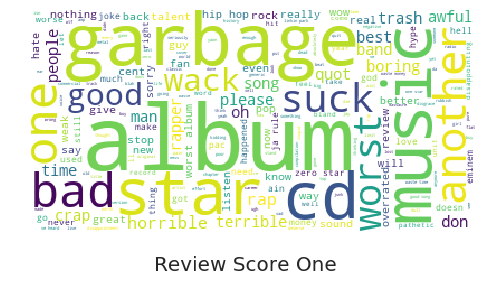

In [77]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

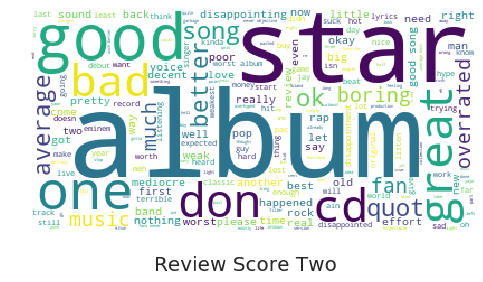

In [78]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

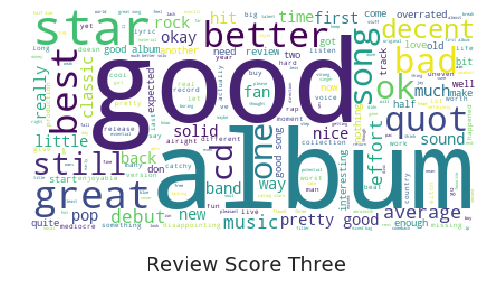

In [79]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

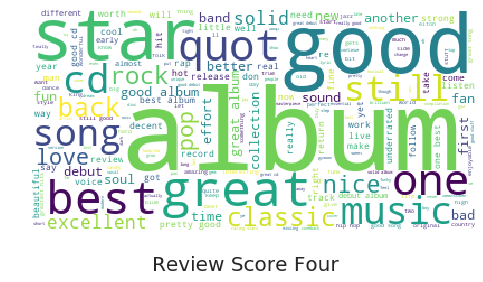

In [80]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

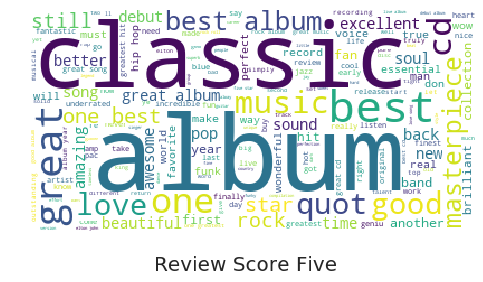

In [81]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")